In [ ]:
# default_exp models.TSTransformerPlus

# TSTransformerPlus

> This is a PyTorch implementation created by Ignacio Oguiza (timeseriesAI@gmail.com).

In [ ]:
#export
from tsai.imports import *
from tsai.models.layers import *
from typing import Callable

In [ ]:
# export

class _TransformerEncoder(nn.Module):
    def __init__(self, d_model, n_heads, n_layers:int=6, encoder_dropout:float=0., act:str='reglu', pre_norm:bool=False):
        super().__init__()
        self.layers = nn.ModuleList([])
        for _ in range(n_layers):
            self.layers.append(nn.ModuleList([
                MultiheadAttention(d_model, n_heads, dropout=encoder_dropout), nn.LayerNorm(d_model), 
                PositionwiseFeedForward(d_model, dropout=encoder_dropout, act=act), nn.LayerNorm(d_model),
            ]))
        self.pre_norm = pre_norm

    def forward(self, x):
        for i, (mha, attn_norm, pwff, ff_norm) in enumerate(self.layers):
            if self.pre_norm: 
                x = mha(attn_norm(x))[0] + x
                x = pwff(ff_norm(x)) + x
            else:
                x = attn_norm(mha(x)[0] + x)
                x = ff_norm(pwff(x) + x)
        return x


class _TSTransformerBackbone(Module):
    def __init__(self, c_in:int, seq_len:int, n_layers:int=6, d_model:int=128, n_heads:int=16, d_head:Optional[int]=None, act:str='reglu',
                 d_ff:int=256, emb_dropout:float=0., encoder_dropout:float=0., pre_norm:bool=False, pct_random_steps:float=1., use_cls_token:bool=True, 
                 custom_subsampling:Optional[Callable]=None, verbose:bool=True):
        
        self.pct_random_steps = pct_random_steps
        self.input_layer = custom_subsampling
        if custom_subsampling is not None:
            xb = torch.randn(1, c_in, seq_len).to(default_device())
            ori_c_in, ori_seq_len = c_in, seq_len
            c_in, seq_len = custom_subsampling.to(default_device())(xb).shape[1:]
            del xb
            pv(f'custom_subsampling: (?, {ori_c_in}, {ori_seq_len}) --> (?, {c_in}, {seq_len})', verbose=verbose)
        self.to_embedding = nn.Sequential(Transpose(1,2), nn.Linear(c_in, d_model))
        self.pos_embedding = nn.Parameter(torch.zeros(1, seq_len + use_cls_token, d_model))
        self.emb_dropout = nn.Dropout(emb_dropout)
        self.cls_token = nn.Parameter(torch.zeros(1, 1, d_model)) if use_cls_token else None

        self.encoder = _TransformerEncoder(d_model, n_heads, n_layers=n_layers, encoder_dropout=encoder_dropout, act=act, pre_norm=pre_norm)

    def forward(self, x):
        
        # apply custom_input_layer (if available)
        if self.input_layer is not None:
            x = self.input_layer(x)

        B, _, S = x.shape

        x = self.to_embedding(x)
        if self.training and self.pct_random_steps < 1.:
            idxs = np.tile(np.random.choice(S, round(S * self.pct_random_steps), False), math.ceil(1 / self.pct_random_steps))[:S]
            x = x[:, idxs]
        if self.cls_token is not None: 
            x = torch.cat((self.cls_token.repeat(B, 1, 1), x), dim=1)
        x += self.pos_embedding
        x = self.emb_dropout(x)        
        
        x = self.encoder(x)

        x = x.transpose(1,2)
        return x


class TSTransformerPlus(nn.Sequential):
    """Time series transformer model based on ViT (Vision Transformer):
    Dosovitskiy, A., Beyer, L., Kolesnikov, A., Weissenborn, D., Zhai, X., Unterthiner, T., ... & Houlsby, N. (2020). 
    An image is worth 16x16 words: Transformers for image recognition at scale. arXiv preprint arXiv:2010.11929.
    
        Args:
            c_in: the number of features (aka variables, dimensions, channels) in the time series dataset.
            c_out: the number of target classes.
            seq_len: number of time steps in the time series.
            n_layers: number of layers (or blocks) in the encoder. Default: 3 (range(1-4))
            d_model: total dimension of the model (number of features created by the model). Default: 128 (range(64-512))
            n_heads:  parallel attention heads. Default:16 (range(8-16)).
            d_head: size of the learned linear projection of queries, keys and values in the MHA. Usual values: 16-512. Default: None -> (d_model/n_heads) = 32.
            d_ff: the dimension of the feedforward network model. Default: 512 (range(256-512))
            act: the activation function of intermediate layer, relu, gelu, geglu, reglu.
            pre_norm: if True normalization will be applied as the first step in the sublayers. Defaults to False
            emb_dropout: dropout applied to to the embedded sequence steps.
            encoder_dropout: dropout applied to the encoder (MultheadAttention and PositionwiseFeedForward layers).
            bn: indicates if batchnorm will be applied to the head.
            fc_dropout: dropout applied to the final fully connected layer.
            y_range: range of possible y values (used in regression tasks).
            custom_head: custom head that will be applied to the network. It must contain all kwargs (pass a partial function)

        Input shape:
            x: bs (batch size) x nvars (aka features, variables, dimensions, channels) x seq_len (aka time steps)
    """
    
    
    def __init__(self, c_in:int, c_out:int, seq_len:int, n_layers:int=6, d_model:int=128, n_heads:int=16, d_head:Optional[int]=None, act:str='reglu',
                 d_ff:int=256, emb_dropout:float=0., encoder_dropout:float=0., pre_norm:bool=False, use_cls_token:bool=True, pct_random_steps:float=1., 
                 fc_dropout:float=0., bn:bool=True, y_range:Optional[tuple]=None, custom_subsampling:Optional[Callable]=None, 
                 custom_head:Optional[Callable]=None, verbose:bool=True):
        
        backbone = _TSTransformerBackbone(c_in, seq_len, n_layers=n_layers, d_model=d_model, n_heads=n_heads, d_head=d_head, act=act,
                                          d_ff=d_ff, emb_dropout=emb_dropout, encoder_dropout=encoder_dropout,
                                          pre_norm=pre_norm, pct_random_steps=pct_random_steps, use_cls_token=use_cls_token, 
                                          custom_subsampling=custom_subsampling, verbose=verbose)
        
        self.head_nf = d_model
        self.c_out = c_out
        self.seq_len = seq_len
        if custom_head: head = custom_head(self.head_nf, c_out, self.seq_len) # custom head passed as a partial func with all its kwargs
        else: 
            layers = [TokenLayer(token=use_cls_token)]
            layers += [LinBnDrop(d_model, c_out, bn=bn, p=fc_dropout)]
            if y_range: layers += [SigmoidRange(*y_range)]
        super().__init__(OrderedDict([('backbone', backbone), ('head', nn.Sequential(*layers))]))

In [ ]:
bs = 16
nvars = 4
seq_len = 50
c_out = 2
xb = torch.rand(bs, nvars, seq_len)
model = TSTransformerPlus(nvars, c_out, seq_len)
test_eq(model(xb).shape, (bs, c_out))
model

TSTransformerPlus(
  (backbone): _TSTransformerBackbone(
    (to_embedding): Sequential(
      (0): Transpose(1, 2)
      (1): Linear(in_features=4, out_features=128, bias=True)
    )
    (emb_dropout): Dropout(p=0.0, inplace=False)
    (encoder): _TransformerEncoder(
      (layers): ModuleList(
        (0): ModuleList(
          (0): MultiheadAttention(
            (W_Q): Linear(in_features=128, out_features=128, bias=False)
            (W_K): Linear(in_features=128, out_features=128, bias=False)
            (W_V): Linear(in_features=128, out_features=128, bias=False)
            (sdp_attn): ScaledDotProductAttention()
            (to_out): Sequential(
              (0): Linear(in_features=128, out_features=128, bias=True)
              (1): Dropout(p=0.0, inplace=False)
            )
          )
          (1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (2): PositionwiseFeedForward(
            (0): Linear(in_features=128, out_features=256, bias=True)
            

### Subsampling

It's a known fact that transformers cannot be directly applied to long sequences. To avoid this, we have included a way to subsample the sequence to generate a more manageable input.

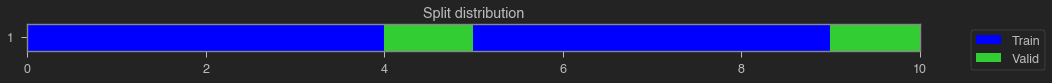

TSTensor(samples:8, vars:3, len:5000)

In [ ]:
from tsai.data.validation import get_splits
from tsai.data.core import get_ts_dls
X = np.zeros((10, 3, 5000)) 
y = np.random.randint(0,2,X.shape[0])
splits = get_splits(y)
dls = get_ts_dls(X, y, splits=splits)
xb, yb = dls.train.one_batch()
xb

If you try to use TSTransformerPlus, it's likely you'll get an 'out-of-memory' error.

To avoid this you can subsample the sequence reducing the input's length. This can be done in multiple ways. Here are a few examples: 

In [ ]:
# Separable convolution (to avoid mixing channels)
custom_subsampling = Conv1d(xb.shape[1], xb.shape[1], ks=100, stride=50, padding='same', groups=xb.shape[1]).to(default_device())
custom_subsampling(xb).shape

torch.Size([8, 3, 100])

In [ ]:
# Convolution (if you want to mix channels or change number of channels)
custom_subsampling = Conv1d(xb.shape[1], 2, ks=100, stride=50, padding='same').to(default_device())
custom_subsampling(xb).shape

torch.Size([8, 2, 100])

In [ ]:
# MaxPool
custom_subsampling = nn.Sequential(Pad1d((0, 50), 0), nn.MaxPool1d(kernel_size=100, stride=50)).to(default_device())
custom_subsampling(xb).shape

torch.Size([8, 3, 100])

In [ ]:
# AvgPool
custom_subsampling = nn.Sequential(Pad1d((0, 50), 0), nn.AvgPool1d(kernel_size=100, stride=50)).to(default_device())
custom_subsampling(xb).shape

torch.Size([8, 3, 100])

Once you decide what type of transform you want to apply, you just need to pass the layer as the custom_subsampling attribute:

In [ ]:
bs = 16
nvars = 4
seq_len = 1000
c_out = 2
xb = torch.rand(bs, nvars, seq_len)
custom_subsampling = Conv1d(xb.shape[1], xb.shape[1], ks=5, stride=3, padding='same', groups=xb.shape[1])
model = TSTransformerPlus(nvars, c_out, seq_len, custom_subsampling=custom_subsampling)
test_eq(model(xb).shape, (bs, c_out))

custom_subsampling: (?, 4, 1000) --> (?, 4, 334)


In [ ]:
#hide
out = create_scripts()
beep(out)

<IPython.core.display.Javascript object>

Converted 000_utils.ipynb.
Converted 000b_data.validation.ipynb.
Converted 000c_data.preparation.ipynb.
Converted 001_data.external.ipynb.
Converted 002_data.core.ipynb.
Converted 002b_data.unwindowed.ipynb.
Converted 002c_data.metadatasets.ipynb.
Converted 003_data.preprocessing.ipynb.
Converted 003b_data.transforms.ipynb.
Converted 003c_data.mixed_augmentation.ipynb.
Converted 003d_data.image.ipynb.
Converted 003e_data.features.ipynb.
Converted 005_data.tabular.ipynb.
Converted 006_data.mixed.ipynb.
Converted 050_losses.ipynb.
Converted 051_metrics.ipynb.
Converted 052_learner.ipynb.
Converted 052b_tslearner.ipynb.
Converted 053_optimizer.ipynb.
Converted 060_callback.core.ipynb.
Converted 061_callback.noisy_student.ipynb.
Converted 062_callback.gblend.ipynb.
Converted 063_callback.MVP.ipynb.
Converted 064_callback.PredictionDynamics.ipynb.
Converted 100_models.layers.ipynb.
Converted 100b_models.utils.ipynb.
Converted 100c_models.explainability.ipynb.
Converted 101_models.ResNet.ipy